# Pyncov-19: Simulating the spread of SARS-CoV-2

Pyncov-19 is a tiny probabilistic simulator for SARS-CoV-2 implemented in Python 3, whose only dependency is Numpy 1.18.
This simulator is used to learn and predict the temporal dynamics of COVID-19 that are shown in https://covid19-modeling.github.io. It implements a probabilistic compartmental model at the individual level using a Markov Chain model with temporal transitions that were adjusted using the most recent scientific evidence.

This library is still a proof-of-concept and it's inteded only to be used for research and experimentation. For more information please read our [preprint](https://arxiv.org/abs/2004.13695):


    Matabuena, M., Meijide-García, C., Rodríguez-Mier, P., & Leborán, V. (2020). 
    COVID-19: Estimating spread in Spain solving an inverse problem with a probabilistic model. 
    arXiv preprint arXiv:2004.13695. https://arxiv.org/abs/2004.13695


This model's main goal is to estimate the levels of infections (or the seroprevalence) of the population, using only data from the registered deaths caused by COVID-19. Although the model can be used to make future predictions (evolution of infections, fatalities, etc.), that's not the primary purpose of the model. Given the uncertainty about essential events that alter the course and dynamics of the spread (for example, the use of masks, lockdowns, social distance, etc.), it is tough to make accurate predictions, so we limit ourselves to use the model to reveal more information about what happened before (backcasting).


@author: Pablo Rodríguez Mier ([@pablormier](https://twitter.com/pablormier))

In [1]:
%matplotlib inline
import sys
sys.path.append('../')

# Extra libs: required for plotting and data manipulation only
import pandas as pd
import matplotlib.pyplot as plt

import pyncov as nc
import pyncov.io
import pyncov.plot
import pyncov.datasets
import numpy as np

print('pyncov-19', nc.__version__)
print('numpy', np.__version__)
print('pandas', pd.__version__)

try:
    plt.style.use('seaborn-whitegrid')
except:
    print('Using default style')

figsize = (16, 6)

pyncov-19 0.1.5
numpy 1.18.1
pandas 1.0.3


## What's inside the model?

Pyncov-19 implements a compartmental model based on a Markov Chain with temporal transitions, consisting of six states:
- I1: Infected, incubating the virus
- I2: Infected, mild symptoms or asymptomatic
- I3: Infected, severe symptoms
- R1: Recovered, but still infectious
- R2: Recovered, cannot infect
- M0: Dead


People infected will move between the different states using the Markov Chain and scheduled on a daily basis. The simulator samples the transition and the time at which each person is going to transit each day. For example, a recently infected person in state I1 (incubating the virus) will move with some probability to I2 (mild symptoms or asymptomatic) or I3 (severe symptoms). If the person is determined to move to I2, it will transit to this state after a concrete number of days, which is sampled from a distribution. On average, people incubating the virus (I1) will present symptoms on the fifth day after contracting the virus. Still, in some situations, the incubation period is slower, and symptoms present after 9-10 days. 




Each day, the simulator injects new infected people in the system, sampling from a $Poisson(\lambda_t)$. The number of new infections entering the system is on average $\lambda_t$, and it depends on two factors: the number of people who can infect $k_t$ at time $t$, and the dynamic individual reproductive number $Ri_t$. 

In our model, $\lambda_t$ is defined as $\lambda_t = k_t * Ri_t$. This dynamic individual reproductive number cannot be directly compared with the reproduction number $R_t$ used in traditional ODE-based models (SIR and variants). Its interpretation and analysis is more complicated.

People infected will move between the different states using the Markov Chain, scheduled on a daily basis. The simulator samples the transition and the time at which each person is going to transit each day. For example, a recently infected person in state I1 (incubating the virus), will move with some probability to I2 (mild symptoms or asymptomatic) or I3 (severe symptoms). If the person is determined to move to I2, it will transit to this state after a concrete number of days, which is sampled from a distribution. On average, people incubating the virus (I1) will present symptoms on the fifth day after contracting the virus. Still, in some situations, the incubation period is slower, and symptoms present after 9-10 days.

Distributions are adequately configured in Pyncov-19 using the current evidence in the scientific literature. However, that can be changed to model other situations or explore different scenarios.

In order to explore the default configuration of the model, we can sample days using the timeSimulator in pyncov-19:

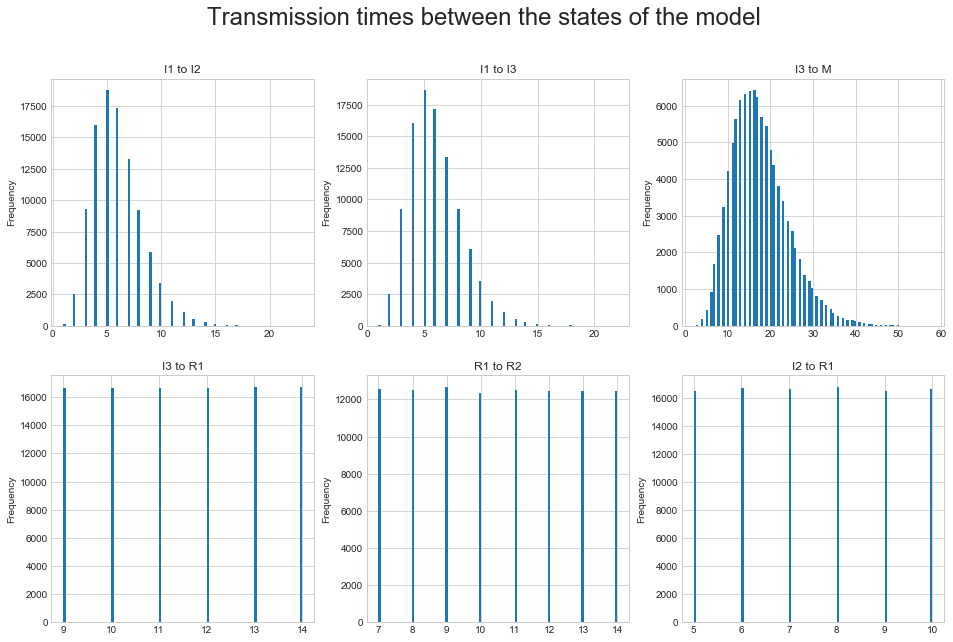

In [2]:
# Configuration of the markov chain
n = 100000
bins = 100
m = nc.build_markovchain(nc.MARKOV_DEFAULT_PARAMS)
fig, ax = plt.subplots(2, 3, figsize=(16, 10))
fig.suptitle("Transmission times between the states of the model", fontsize=24)
pd.Series(m.timeSimulator[nc.S.I1, nc.S.I2](n)).plot.hist(bins=bins, ax=ax[0,0], title='I1 to I2');
pd.Series(m.timeSimulator[nc.S.I1, nc.S.I3](n)).plot.hist(bins=bins, ax=ax[0,1], title='I1 to I3');
pd.Series(m.timeSimulator[nc.S.I3, nc.S.M0](n)).plot.hist(bins=bins, ax=ax[0,2], title='I3 to M');
pd.Series(m.timeSimulator[nc.S.I3, nc.S.R1](n)).plot.hist(bins=bins, ax=ax[1,0], title='I3 to R1');
pd.Series(m.timeSimulator[nc.S.R1, nc.S.R2](n)).plot.hist(bins=bins, ax=ax[1,1], title='R1 to R2');
pd.Series(m.timeSimulator[nc.S.I2, nc.S.R1](n)).plot.hist(bins=bins, ax=ax[1,2], title='I2 to R1');

## Dynamic individual infection rate $R_i(t)$


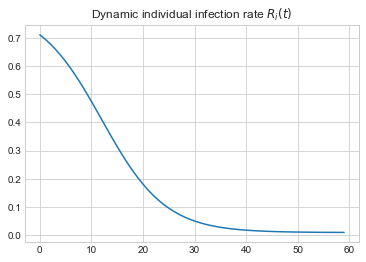

In [3]:
infection_rates = nc.infection_rates([0.8, 0.85, 12, 0.01], num_days=60)
pd.Series(infection_rates).plot(title="Dynamic individual infection rate $R_i(t)$");

Using this configuration as an example, we can start doing simulations of the different trajectories that the epidemic can follow for a given population. The method sample_chains allows to generate C chains. It returns a matrix of shape (C, D, S) where C are the chains (simulations), D are the simulated days, and S are the states.

In [4]:
num_chains = 100
initial_infections = 1
susceptible_population = 999999
population = initial_infections + susceptible_population
num_days = 60

simulations = nc.sample_chains(susceptible_population, initial_infections, m, infection_rates, 
                               num_chains=num_chains, n_workers=4, show_progress=True)

In [5]:
# The dimensions are num_chains x num_days x states
simulations.shape

(100, 60, 6)

In [6]:
# Get the new infections of the first simulation
simulations[0,:,nc.S.I1].astype(int)

array([   0,    1,    3,    4,    7,   13,   20,   26,   47,   69,   97,
        157,  210,  284,  371,  471,  611,  758,  942, 1104, 1248, 1432,
       1608, 1736, 1832, 1927, 1956, 1967, 1949, 1910, 1791, 1706, 1599,
       1536, 1449, 1365, 1287, 1209, 1123, 1039,  958,  877,  786,  710,
        652,  590,  532,  474,  447,  406,  380,  345,  336,  293,  264,
        246,  221,  204,  177,  158])

## Visualizing trajectories

Let's represent the infections and fatalities of one of the possible scenarios. 

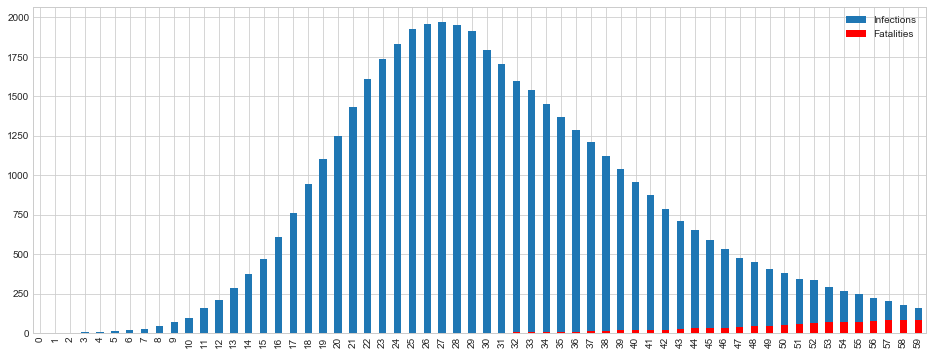

In [7]:
fig, ax = plt.subplots(figsize=figsize)
pd.Series(simulations[0,:,nc.S.I1], name='Infections').plot.bar(ax=ax, legend=True);
pd.Series(simulations[0,:,nc.S.M0], name='Fatalities').plot.bar(ax=ax, color='r', legend=True);

What's more interesting is to plot all the simulated trajectories for different states of the model. The simulator generates many trajectories of events that could happend, assuming the current configuration and infection rate.

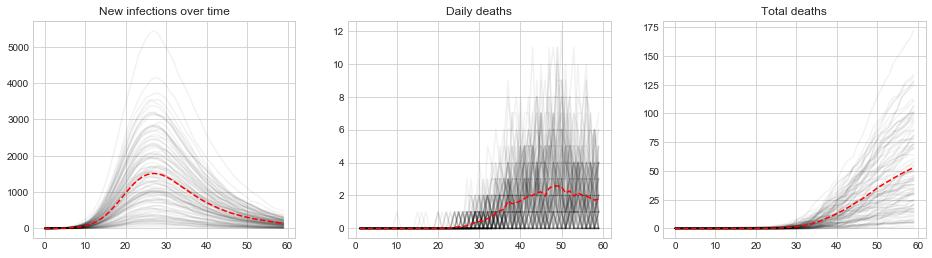

In [8]:
fig, ax = plt.subplots(1, 3, figsize=(16,4))
nc.plot.plot_state(simulations, nc.S.I1, ax=ax[0], title="New infections over time")
nc.plot.plot_state(simulations, nc.S.M0, diff=True, ax=ax[1], title="Daily deaths")
nc.plot.plot_state(simulations, nc.S.M0, ax=ax[2], title="Total deaths")

# Visualizing real data

From version v0.1.5, Pyncov-19 includes a module datasets to easily import data from the CSSE (Johns Hopkins University). 

In [74]:
df_global = nc.datasets.load_csse_global_fatalities()
# Get only country level
df_global = df_global[df_global.index.get_level_values('n2').isna()]
df_global.head()

,,,,,2020-01-22,2020-01-23,2020-01-24,2020-01-25,2020-01-26,2020-01-27,2020-01-28,2020-01-29,2020-01-30,2020-01-31,...,2020-05-30,2020-05-31,2020-06-01,2020-06-02,2020-06-03,2020-06-04,2020-06-05,2020-06-06,2020-06-07,2020-06-08
iso3,iso2,n1,n2,population,,,,,,,,,,,,,,,,,,,,,
AFG,AF,Afghanistan,NaN,37172386,0,0,0,0,0,0,0,0,0,0,...,249,257,265,270,294,300,309,327,357,369
ALB,AL,Albania,NaN,2866376,0,0,0,0,0,0,0,0,0,0,...,33,33,33,33,33,33,33,34,34,34
DZA,DZ,Algeria,NaN,42228429,0,0,0,0,0,0,0,0,0,0,...,646,653,661,667,673,681,690,698,707,715
AND,AD,Andorra,NaN,77006,0,0,0,0,0,0,0,0,0,0,...,51,51,51,51,51,51,51,51,51,51
AGO,AO,Angola,NaN,30809762,0,0,0,0,0,0,0,0,0,0,...,4,4,4,4,4,4,4,4,4,4


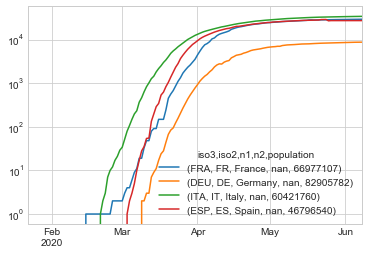

In [87]:
df_global.loc[['FRA','ESP','ITA','DEU']].transpose().plot(logy=True)

# Simulations with real data

In this example, we are going to load data from Spain and we are going to simulate the possible transmission chains.

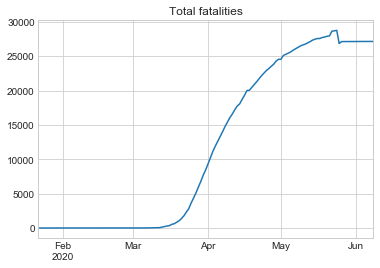

In [46]:
df_spain = nc.datasets.load_csse_global_fatalities().query("n1 == 'Spain'")
susceptible = df_spain.index.get_level_values('population').values[0]

df_spain.squeeze().plot(title='Total fatalities')

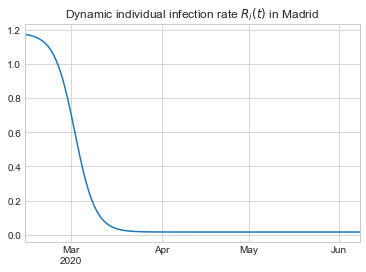

In [47]:
df = df_spain.squeeze()
# Remove some zeros to align the data
df = df.reindex(pd.date_range(df.index[0] + 23 * df.index.freq, df.index[-1]), fill_value=0)

# Parameters were obtained by fitting the stochastic model with CMA-ES. Training the model is out of the scope of this tutorial.
# NOTE: Remember that the Ri(t) function is not like the R(t) reproductive number of classical models.
infection_rates = nc.infection_rates(nc.io.get_trained_params('ESP'), num_days=len(df.index))
pd.Series(infection_rates, index=df.index).plot(title="Dynamic individual infection rate $R_i(t)$ in Madrid");

In [50]:
# Simulate using the population from Madrid (~6.680.000)
# Use 4 processed to parallelize the generation of the chains
simulations = nc.sample_chains(susceptible, initial_infections, m, infection_rates, 
                               num_chains=100, n_workers=4, show_progress=True)

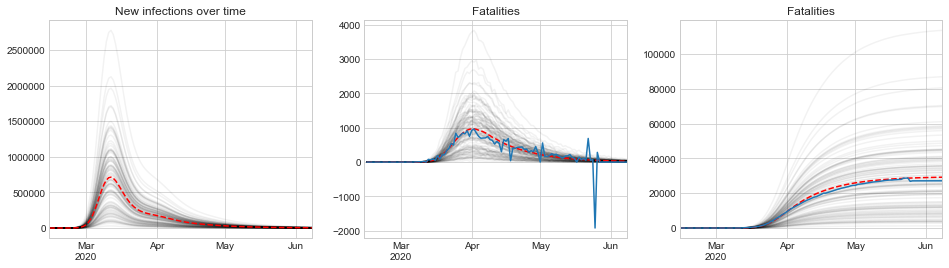

In [51]:
fig, ax = plt.subplots(1, 3, figsize=(16,4))
nc.plot.plot_state(simulations, nc.S.I1, ax=ax[0], index=df.index, title="New infections over time")
nc.plot.plot_state(simulations, nc.S.M0, diff=True, ax=ax[1], index=df.index, title="Fatalities")
nc.plot.plot_state(simulations, nc.S.M0, ax=ax[2], index=df.index, title="Fatalities")
df.diff().plot(ax=ax[1])
df.plot(ax=ax[2])